This follows from [single_slit_data_dl_and_pipeline](single_slit_data_dl_and_pipeline.ipynb) and [single_exposure_modeling_wcupy_realdata](single_exposure_modeling_wcupy_realdata.ipynb) as an experiment on how to express a single slit's processing, as a precursor to a template for batch processing (a la [TEMPLATETARGETNAME_SLITNAME_slit_dl_and_pipeline](TEMPLATETARGETNAME_SLITNAME_slit_dl_and_pipeline.ipynb)).

In [5]:
from pathlib import Path
import psutil
import pickle

import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import constants

from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler


from jwst import datamodels

%matplotlib inline
from matplotlib import pyplot as plt

from astropy import visualization as aviz
aviz.quantity_support()

import cupy as cp

import webbpsf

import dynesty
from dynesty import plotting as dyplot

from tqdm.notebook import tqdm

In [6]:
def libc_freemem():
    import ctypes
    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)

In [7]:
psutil.Process().memory_info().rss / 1048576 #MiB

348.41015625

In [8]:
slit_name = 's00066'

redux_path = Path(f'data/jwst_outputs/redux_{slit_name}/')
[(p.name, p.is_symlink()) for p in redux_path.iterdir()]

[('jw02609010001_03101_00002_nrs2_cal.fits', False),
 ('jw02609010001_03101_00001_nrs1_interpolatedflat.fits', False),
 ('jw02609010001_01_msa.fits', True),
 ('jw02609-o010_20240212t021359_spec2_00001_asn.json', False),
 ('jw02609010001_03101_00002_nrs2_rate.fits', True),
 ('jw02609010001_03101_00002_nrs2_interpolatedflat.fits', False),
 ('jw02609-o010_20240212t021359_spec2_00003_asn.json', False),
 ('jw02609010001_03101_00001_nrs1_rate.fits', True),
 ('completed_pipeline_run', False),
 ('jw02609010001_03101_00001_nrs1_cal.fits', False),
 ('jw02609010001_03101_00002_nrs1_interpolatedflat.fits', False),
 ('jw02609010001_03101_00001_nrs2_interpolatedflat.fits', False),
 ('jw02609-o010_20240212t021359_spec2_00002_asn.json', False),
 ('jw02609010001_03101_00002_nrs1_rate.fits', True),
 ('jw02609-o010_20240212t021359_spec2_00004_asn.json', False),
 ('jw02609010001_03101_00001_nrs2_rate.fits', True),
 ('jw02609010001_03101_00002_nrs1_cal.fits', False),
 ('jw02609010001_03101_00001_nrs2_cal.f

In [9]:
cal_paths = list(redux_path.glob('*cal.fits'))
cal_paths

[PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs2_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00002_nrs1_cal.fits'),
 PosixPath('data/jwst_outputs/redux_s00066/jw02609010001_03101_00001_nrs2_cal.fits')]

In [10]:
psutil.Process().memory_info().rss / 1048576 #MiB

348.41015625

In [11]:
%time cal_dms = {p.name: datamodels.open(p) for p in tqdm(cal_paths)}

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 1min 5s, sys: 6.6 s, total: 1min 12s
Wall time: 1min 13s


In [12]:
psutil.Process().memory_info().rss / 1048576 #MiB

1676.12109375

In [13]:
del cal_dms

In [14]:
import gc
gc.collect()

psutil.Process().memory_info().rss / 1048576 #MiB

1414.16015625

In [15]:
libc_freemem()
psutil.Process().memory_info().rss / 1048576 #MiB

914.37109375

Alright this shows that we can't necessarily claim back all the memory from the datamodels?  But some.

In [16]:
cal_dms = {p.name: datamodels.open(p) for p in tqdm(cal_paths)}
cal_dms

  0%|          | 0/4 [00:00<?, ?it/s]

{'jw02609010001_03101_00002_nrs2_cal.fits': <MultiSlitModel from jw02609010001_03101_00002_nrs2_cal.fits>,
 'jw02609010001_03101_00001_nrs1_cal.fits': <MultiSlitModel from jw02609010001_03101_00001_nrs1_cal.fits>,
 'jw02609010001_03101_00002_nrs1_cal.fits': <MultiSlitModel from jw02609010001_03101_00002_nrs1_cal.fits>,
 'jw02609010001_03101_00001_nrs2_cal.fits': <MultiSlitModel from jw02609010001_03101_00001_nrs2_cal.fits>}

In [17]:
psutil.Process().memory_info().rss / 1048576 #MiB

1678.08984375

But its not leaking memory at least, so maybe we don't care.

# IDing of slit

Hunt through the metadata to figure out how to ID a specific slit

In [18]:
dm_example = next(iter(cal_dms.values()))
dm_example.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 3.1.0
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 6ab9c1dac878f7cbdc7d3245c0fbdf254674db16438d467ff9a29e8a8ff4c51a
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─asn (dict) ...
│ ├─bunit_data (str): DN/s
│ ├─bunit_err (str): DN/s
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ ├─calibration_software_version (str): 1.13.4
│ ├─compress (bool): False
│ ├─coordinates (dict) ...
│ ├─data_processing_software_version (str): 2023_3b
│ ├─date (str): 2024-02-29T19:10:36.555
│ └─27 not shown
└─slits (list) ...
Some nodes not shown.


In [19]:
list(dm_example.meta.items())

[('aperture.name', 'NRS_FULL_MSA'),
 ('aperture.position_angle', 318.1435242947994),
 ('aperture.pps_name', 'NRS_FULL_MSA'),
 ('asn.pool_name', 'jw02609_20240212t021359_pool.csv'),
 ('asn.table_name', 'jw02609-o010_20240212t021359_spec2_00001_asn.json'),
 ('bunit_data', 'DN/s'),
 ('bunit_err', 'DN/s'),
 ('cal_step.assign_wcs', 'COMPLETE'),
 ('cal_step.barshadow', 'COMPLETE'),
 ('cal_step.charge_migration', 'SKIPPED'),
 ('cal_step.dark_sub', 'COMPLETE'),
 ('cal_step.dq_init', 'COMPLETE'),
 ('cal_step.extract_2d', 'COMPLETE'),
 ('cal_step.flat_field', 'COMPLETE'),
 ('cal_step.gain_scale', 'COMPLETE'),
 ('cal_step.group_scale', 'SKIPPED'),
 ('cal_step.imprint', 'SKIPPED'),
 ('cal_step.ipc', 'SKIPPED'),
 ('cal_step.jump', 'COMPLETE'),
 ('cal_step.linearity', 'COMPLETE'),
 ('cal_step.master_background', 'SKIPPED'),
 ('cal_step.msa_flagging', 'COMPLETE'),
 ('cal_step.nsclean', 'SKIPPED'),
 ('cal_step.pathloss', 'COMPLETE'),
 ('cal_step.photom', 'COMPLETE'),
 ('cal_step.pixel_replace', 'SKIPP

In [20]:
list(dm_example.slits[0])

['barshadow',
 'data',
 'dither_position',
 'dq',
 'err',
 'int_times',
 'meta.aperture.name',
 'meta.aperture.position_angle',
 'meta.aperture.pps_name',
 'meta.bunit_data',
 'meta.bunit_err',
 'meta.cal_step.assign_wcs',
 'meta.cal_step.charge_migration',
 'meta.cal_step.dark_sub',
 'meta.cal_step.dq_init',
 'meta.cal_step.gain_scale',
 'meta.cal_step.group_scale',
 'meta.cal_step.imprint',
 'meta.cal_step.ipc',
 'meta.cal_step.jump',
 'meta.cal_step.linearity',
 'meta.cal_step.msa_flagging',
 'meta.cal_step.nsclean',
 'meta.cal_step.ramp_fit',
 'meta.cal_step.refpix',
 'meta.cal_step.saturation',
 'meta.cal_step.superbias',
 'meta.calibration_software_revision',
 'meta.calibration_software_version',
 'meta.compress',
 'meta.coordinates.reference_frame',
 'meta.data_processing_software_version',
 'meta.date',
 'meta.dither.nod_type',
 'meta.dither.position_number',
 'meta.dither.primary_type',
 'meta.dither.total_points',
 'meta.dither.x_offset',
 'meta.dither.y_offset',
 'meta.ephem

In [21]:
sids = np.array([s.source_id for s in dm_example.slits])
matches = sids == int(slit_name.replace('s', ''))

assert np.sum(matches)==1
idx = np.where(matches)[0][0]

slit = dm_example.slits[idx]

(<matplotlib.image.AxesImage at 0x7f782b7c6c50>,
 <astropy.visualization.mpl_normalize.ImageNormalize at 0x7f782ecebf50>)

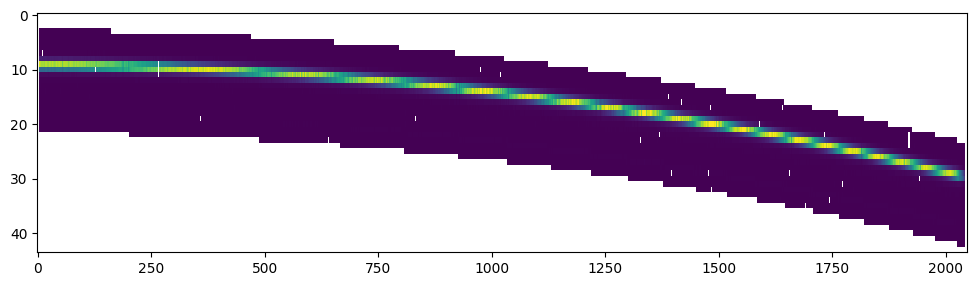

In [22]:
plt.figure(figsize=(12, 5))
aviz.imshow_norm(slit.data,
                 interval=aviz.AsymmetricPercentileInterval(.1, 99.9),
                 stretch=aviz.LinearStretch(),
                 aspect=12,
                 interpolation='nearest'
                )

Looks like a slit! Huzzah!

Now lets try a slit with an actual star in it - see [get_apogee_cluster_data.ipynb](get_apogee_cluster_data.ipynb) for more on IDing the slits. The ones that are in apogee are 42,10,38,40,21,150 (although 40 is saturated so probably useless).  The obvious choice is 42...

We *should* probably use the slit as loaded from redux_s0042, but for testing here we will just use the same one since it's the same exposures right now

In [23]:
slit_all = {}
for k, dm in cal_dms.items():
    matches = np.array([s.source_id for s in dm.slits]) == 42
    assert np.sum(matches)==1
    idx = np.where(matches)[0][0]

    slit_all[k] = dm.slits[idx]

In [24]:
slit_all

{'jw02609010001_03101_00002_nrs2_cal.fits': <stdatamodels.properties.ObjectNode at 0x7f78239fcc90>,
 'jw02609010001_03101_00001_nrs1_cal.fits': <stdatamodels.properties.ObjectNode at 0x7f782d1b8950>,
 'jw02609010001_03101_00002_nrs1_cal.fits': <stdatamodels.properties.ObjectNode at 0x7f7810c31910>,
 'jw02609010001_03101_00001_nrs2_cal.fits': <stdatamodels.properties.ObjectNode at 0x7f781f4d8e10>}

/usr/local/lib/python3.11/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


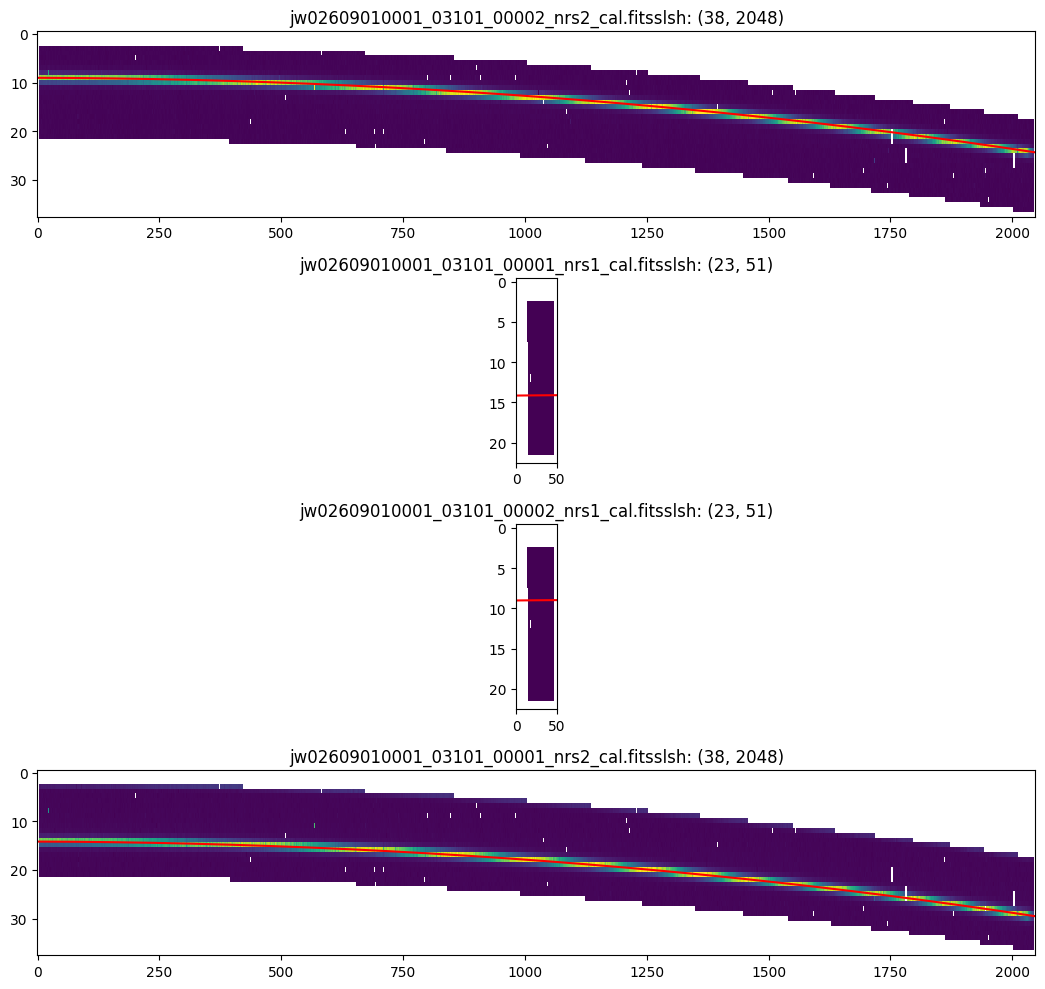

In [25]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

for ax, (k, slit) in zip(axs.ravel(), slit_all.items()):
    aviz.imshow_norm(slit.data, ax=ax,
                 interval=aviz.AsymmetricPercentileInterval(.1, 99.9),
                 stretch=aviz.LinearStretch(),
                 aspect=10,
                 interpolation='nearest'
                )
    
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    xs, ys = slit.meta.wcs.world_to_pixel(SkyCoord(slit.source_ra, slit.source_dec, unit=u.deg), np.linspace(0.5, 2, 1024)*u.micron)
    ax.plot(xs, ys, c='r')
    ax.set_xlim(*xl)
    ax.set_ylim(*yl)
    
    ax.set_title(k + f'slsh: {slit.data.shape}')
fig.tight_layout()

It's probably a safe assumption that an exposure with an x-extent less than ~100 is useless?

# Modeling

Lets start with one of the good exposures that's good

In [26]:
slit = slit_all['jw02609010001_03101_00002_nrs2_cal.fits']

Now get an appropriate model. [get_apogee_cluster_data](get_apogee_cluster_data.ipynb) has the info for this:

In [27]:
tegg = 4706.299*u.K
logg= 3.203067
MH = 0.34978	
aFe = 0.057345

vhelio = -45.09741*u.km/u.s # +/- 6? 20 visists

In [28]:
phoenix_model = fits.open('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/PHOENIX-ACES-AGSS-COND-2011/Z+0.5/lte04700-3.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits', cache=True)
phoenix_wave = fits.getdata('ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS//WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', cache=True)*u.angstrom

phoenix_spec = Spectrum1D(spectral_axis=phoenix_wave, flux=phoenix_model[0].data*u.Unit(phoenix_model[0].header['BUNIT']))

2024-02-29 19:22:41,769 - stpipe - WARNING - UnitsWarning: 'erg/s/cm^2/cm' contains multiple slashes, which is discouraged by the FITS standard


Now we sub-sample to not have to use the full resolution phoenix model.

NOTE: this doesn't allow for any sub-spectrum to dangle off the data edges.  For any significant redshift that might be an issue.

In [29]:
wls = np.quantile(slit.wavelength[np.isfinite(slit.wavelength)], [0, .5,1])*u.micron

msk = (wls[0] <= phoenix_spec.spectral_axis) & (phoenix_spec.spectral_axis<=wls[-1])

phoenix_sub_spec = Spectrum1D(spectral_axis=phoenix_spec.spectral_axis[msk], 
                                        flux=phoenix_spec.flux[msk])

In [30]:
dmodel = np.diff(phoenix_sub_spec.spectral_axis)

phoenix_lowres_wls_dlamb = np.max(dmodel)*10
phoenix_lowres_wl_bins = np.arange(wls[0].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   wls[-1].to(phoenix_lowres_wls_dlamb.unit).value, 
                                   phoenix_lowres_wls_dlamb.to(phoenix_lowres_wls_dlamb.unit).value)*phoenix_lowres_wls_dlamb.unit

phoenix_lowres = FluxConservingResampler().resample1d(phoenix_sub_spec, 
                            (phoenix_lowres_wl_bins[:-1] + phoenix_lowres_wl_bins[1:])/2)

len(phoenix_lowres.spectral_axis)/slit.data.shape[1]  # tells how much better sampled the "low" res spectrum is from the data

11.77783203125

And then we construct a PSF (note we don't actually need NRS1 here but other spectra will need it).

In [38]:
%%time

wnsn2 = webbpsf.NIRSpec()

wnsn2.detector = 'NRS2'
wnsn2.image_mask = 'Single MSA open shutter'

psfn2 = wnsn2.calc_psf(monochromatic=(wls[1]).to(u.meter).value, oversample=4, fov_pixels=2*3)

CPU times: user 2.96 s, sys: 3.37 s, total: 6.33 s
Wall time: 3.46 s


In [39]:
%%time

wnsn1 = webbpsf.NIRSpec()

wnsn1.detector = 'NRS1'
wnsn1.image_mask = 'Single MSA open shutter'

psfn1 = wnsn1.calc_psf(monochromatic=(wls[1]).to(u.meter).value, oversample=4, fov_pixels=2*3)

CPU times: user 717 ms, sys: 152 ms, total: 868 ms
Wall time: 704 ms


We can now construct our CUDA kernel to do the convolution into the data space:

In [40]:
"""
Kernel design:
Blocks = (nim, yim, xim/tpb)
Threads = fast axis of image
"""

convolve_fluxline_src = r"""
extern "C" __global__
void convolve_fluxline(float* fluxim, 
                       const float* fluxpoints, const float* xcens, const float* ycens,
                       const float* psf, const float* pxls, const float* pxus, const float* pyls, const float* pyus,
                       const float psfmaxdistsq, const int nspec, const int psfsize, const float psfpxsz) {
    float fluxaccum = 0;

    float gycen = blockIdx.y;
    float gyl = blockIdx.y - 0.5f;
    float gyu = blockIdx.y + 0.5f;
    
    float gxcen = blockIdx.z * blockDim.x + threadIdx.x;
    float gxl = gxcen - 0.5f;
    float gxu = gxcen + 0.5f;

    for (int i = 0; i < nspec; i++) {
        float xc = xcens[i];
        float yc = ycens[i];

        float dx = xc - gxcen;
        float dy = yc - gycen;
        if ((dx*dx + dy*dy) < psfmaxdistsq) {
            for (int j=0; j < psfsize; j++) {
                // pxls need to be in *image* pixels, not psf pixels
                float pxl = pxls[j] + xc;
                float pxu = pxl + psfpxsz;
                float pyl = pyls[j] + yc;
                float pyu = pyl + psfpxsz;
                dx = fminf(pxu, gxu) - fmaxf(pxl, gxl);
                if (dx > 0) {
                    dy = fminf(pyu, gyu) - fmaxf(pyl, gyl);
                    if (dy > 0) {
                        fluxaccum += fluxpoints[i]*psf[j]*dx*dy;
                    }
                }
            }
        }
    }

    int subdim = blockDim.x*gridDim.z;
    int fluxidx = threadIdx.x + blockIdx.z*blockDim.x + blockIdx.y*subdim + blockIdx.x*subdim*gridDim.y;
    fluxim[fluxidx] = fluxaccum;

}
"""[1:-1]
convolve_fluxline = cp.RawKernel(convolve_fluxline_src, 'convolve_fluxline')

def do_convolve_fluxline(imdata, wcs, simdata, modelspec, psfhdu, ra, dec, v=0*u.km/u.s, tpb=1024):
    if simdata is None: 
        simdata = np.empty_like(imdata)
        
    c_imdata = cp.array(imdata, copy=False, dtype=cp.float32, ndmin=3)
    c_simdata = cp.array(simdata, copy=False, dtype=cp.float32, ndmin=3)
    
    zp1 = v/constants.c + 1
    x_model, y_model = wcs.world_to_pixel(SkyCoord(ra, dec), modelspec.spectral_axis * zp1)
    c_x_model = cp.asarray(x_model, dtype=cp.float32)
    c_y_model = cp.asarray(y_model, dtype=cp.float32)
    c_modelspec_flux = cp.asarray(modelspec.flux.value, dtype=cp.float32)
    
    
    c_psf = cp.asarray(psfhdu.data, dtype=cp.float32)
    psf_oversampling = psfhdu.header['DET_SAMP']
    xg, yg = np.mgrid[-psfhdu.shape[0]/2:psfhdu.shape[0]/2:psfhdu.shape[0]*1j,
                      -psfhdu.shape[1]/2:psfhdu.shape[1]/2:psfhdu.shape[1]*1j]
    c_pxls = cp.asarray((xg.ravel() - 0.5)/psf_oversampling, dtype=cp.float32)
    c_pxus = cp.asarray((xg.ravel() + 0.5)/psf_oversampling, dtype=cp.float32)
    c_pyls = cp.asarray((yg.ravel() - 0.5)/psf_oversampling, dtype=cp.float32)
    c_pyus = cp.asarray((yg.ravel() + 0.5)/psf_oversampling, dtype=cp.float32)
    c_psfmaxdistsq = cp.float32((np.max([xg, yg])/psf_oversampling/2)**2)

    c_nspec = cp.int64(c_modelspec_flux.size)
    c_psfsize = cp.int64(c_psf.size)
    c_psfpxsize = cp.float32(0.5/psf_oversampling)
    
    convolve_fluxline((c_simdata.shape[0], c_simdata.shape[1], c_simdata.shape[2]/tpb), (tpb,), 
                      (c_simdata, c_modelspec_flux, c_x_model, c_y_model,
                       c_psf, c_pxls, c_pxus, c_pyls, c_pyus, c_psfmaxdistsq,
                       c_nspec, c_psfsize, c_psfpxsize))
    
    return c_simdata

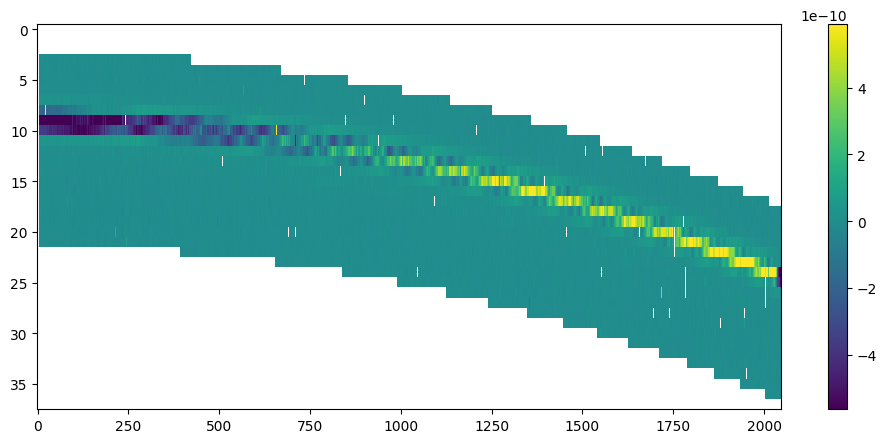

In [41]:
o = .05*u.arcsec
model = do_convolve_fluxline(slit.data, slit.meta.wcs, None, phoenix_lowres, psfn2['OVERDIST'], 
                             ra=(slit.source_ra<<u.deg) + o, 
                             dec=(slit.source_dec<<u.deg) + o)

nans = np.isnan(slit.data)
model_quan = cp.quantile(model[0, ~nans], .99).get()
data_quan = np.quantile(slit.data[~nans], .99)
model_to_data_scale = data_quan/model_quan

datmmod = slit.data - model.get()[0]*model_to_data_scale

plt.figure(figsize=(12, 5))
aviz.imshow_norm(datmmod, aspect='auto',
                          interval=aviz.PercentileInterval(99),
                          stretch=aviz.LinearStretch(),
                          interpolation='nearest')
plt.colorbar();

In [42]:
model_to_data_scale

1.6393762146700666e-22

In [43]:
%timeit model = do_convolve_fluxline(slit.data, slit.meta.wcs, None, phoenix_lowres, psfn2['OVERDIST'],  ra=(slit.source_ra<<u.deg) + o,  dec=(slit.source_dec<<u.deg) + o)

91.6 ms ± 3.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


See [single_exposure_modeling_wcupy_realdata](single_exposure_modeling_wcupy_realdata.ipynb) for justification of these masks 

In [44]:
all32 = (1 << 32) - 1
bits_to_call_bad = all32 & ~(1 << 2) & ~(1 << 15)
bad_msk = (slit.dq & bits_to_call_bad) > 0

masked_data = slit.data.copy()
masked_data[bad_msk] = np.nan

## Inference

The model is pretty straightforward:
* velocity U[-1000, 1000]
* ra/dec offsets from WCS U[-0.5, 0.5]
* model_to_data scale factor (A) 10% to 300% of `model_to_data_scale` U

In [45]:
param_names = 'v,raoff,decoff,A'.split(',')

def ptrans(u):
    x = np.zeros_like(u)
    x[0] = u[0]*2000 - 1000
    x[1:3] = -.5 + u[1:3] #* 1
    x[3] = (u[3]*2.9 + .1)*model_to_data_scale
    return x

GAUSS_LPRETERM = -0.5*np.log(2*np.pi)
kms = u.km/u.s
def loglike(p, data, std, wcs, psfarr, ra0, dec0, logloffset=0):
    v,raoff,decoff,A = p

    ra = ra0 + (raoff << u.arcsec)
    dec = dec0 + (decoff << u.arcsec)
    sim_data = do_convolve_fluxline(data, wcs, None, phoenix_lowres, psfarr, 
                                        v=v<<kms, 
                                        ra=ra0 + (raoff << u.arcsec), 
                                        dec=dec0 + (decoff << u.arcsec)).get()[0]

    
    x = (sim_data*A - data)/std
    loglikes =  -0.5*x**2 - np.log(std) + GAUSS_LPRETERM
    return np.nansum(loglikes) + logloffset

loglike([0, 0, 0, model_to_data_scale], masked_data, slit.err, slit.meta.wcs, psfn2['OVERDIST'], slit.source_ra<<u.deg, slit.source_dec<<u.deg)

91117.953125

In [46]:
np.sum(~np.isnan(masked_data))

38117

OK that promising, the number of pixels ~ matches the loglike so nothing super crazy is happening

### Speed checks

In [47]:
%%timeit 
loglike([0, 0, 0, model_to_data_scale], masked_data, 
                slit.err, slit.meta.wcs, 
                psfn2['OVERDIST'], 
                slit.source_ra<<u.deg, slit.source_dec<<u.deg,
                np.sum(~np.isnan(masked_data)))

108 ms ± 347 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
sampler = dynesty.DynamicNestedSampler(loglike, ptrans, len(param_names), 
                                         logl_args=(masked_data, 
                                                    slit.err, 
                                                    slit.meta.wcs, 
                                                    psfn2['OVERDIST'], 
                                                    slit.source_ra<<u.deg, 
                                                    slit.source_dec<<u.deg,
                                                    np.sum(~np.isnan(masked_data))))
%prun sampler.run_nested(maxcall=10, wt_kwargs={'pfrac': 1.0})

11it [02:26,  1.48s/it, batch: 0 | bound: 0 | nc: 1 | ncall: 11 | eff(%):  2.153 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.294 | dlogz:    inf >  0.010]/usr/local/lib/python3.11/site-packages/dynesty/sampler.py:756: UserWarning: The sampling was stopped short due to maxiter/maxcall limit the delta(log(z)) criterion is not achieved; posterior may be poorly sampled
  warnings.warn('The sampling was stopped short due to'
511it [02:26,  3.49it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 511 | eff(%): 100.000 | loglstar:   -inf < 373426.031 <    inf | logz: 373419.100 +/-  0.133 | dlogz:  1.099 >  0.010]

         148896384 function calls (138949244 primitive calls) in 146.442 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    83804   35.442    0.000   81.034    0.001 core.py:3600(_map_parameters)
    83804   19.805    0.000   33.245    0.000 core.py:3645(_initialize_slices)
      511   11.554    0.023   11.556    0.023 {method 'get' of 'cupy._core.core._ndarray_base' objects}
  9027837    9.819    0.000   11.495    0.000 parameters.py:342(value)
    77672    6.705    0.000   13.629    0.000 core.py:2677(_parameters_to_array)
4081868/83804    6.118    0.000    8.004    0.000 core.py:4184(make_subtree_dict)
3949008/3093594    5.681    0.000    8.629    0.000 core.py:918(__setattr__)
4251530/51101    5.526    0.000   11.351    0.000 copy.py:128(deepcopy)
15173179/15165003    3.479    0.000    3.646    0.000 {built-in method builtins.getattr}
  3443151    2.166    0.000    2.266    0.000 {built-in method numpy.array}
10850392/

Whoa ok almost all the time is spent evaluating the WCS?

In [49]:
%prun do_convolve_fluxline(slit.data, slit.meta.wcs, None, phoenix_lowres, psfn2['OVERDIST'],  ra=(slit.source_ra<<u.deg) + o,  dec=(slit.source_dec<<u.deg) + o)

         291162 function calls (271687 primitive calls) in 0.214 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      164    0.041    0.000    0.065    0.000 core.py:3645(_initialize_slices)
      164    0.017    0.000    0.104    0.001 core.py:3600(_map_parameters)
    17667    0.017    0.000    0.020    0.000 parameters.py:342(value)
      152    0.014    0.000    0.028    0.000 core.py:2677(_parameters_to_array)
7728/6054    0.012    0.000    0.019    0.000 core.py:918(__setattr__)
 8320/100    0.012    0.000    0.025    0.000 copy.py:128(deepcopy)
 7988/164    0.009    0.000    0.013    0.000 core.py:4184(make_subtree_dict)
29679/29663    0.007    0.000    0.008    0.000 {built-in method builtins.getattr}
     6730    0.004    0.000    0.005    0.000 {built-in method numpy.array}
      745    0.004    0.000    0.004    0.000 shapes.py:340(check_broadcast)
    21246    0.003    0.000    0.004    0.000 {built-in method b

yep... core.py here is all in modeling, which is the gwcs execution

In [57]:
x_model, y_model = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg) + o,  (slit.source_dec<<u.deg)), phoenix_lowres.spectral_axis)

def do_convolve_fluxline2(imdata, wcs, simdata, modelspec, psfhdu, ra, dec, v=0*u.km/u.s, tpb=1024):
    if simdata is None: 
        simdata = np.empty_like(imdata)
        
    c_imdata = cp.array(imdata, copy=False, dtype=cp.float32, ndmin=3)
    c_simdata = cp.array(simdata, copy=False, dtype=cp.float32, ndmin=3)
    
    zp1 = v/constants.c + 1
    #x_model, y_model = wcs.world_to_pixel(SkyCoord(ra, dec), modelspec.spectral_axis * zp1)
    c_x_model = cp.asarray(x_model, dtype=cp.float32)
    c_y_model = cp.asarray(y_model, dtype=cp.float32)
    c_modelspec_flux = cp.asarray(modelspec.flux.value, dtype=cp.float32)
    
    
    c_psf = cp.asarray(psfhdu.data, dtype=cp.float32)
    psf_oversampling = psfhdu.header['DET_SAMP']
    xg, yg = np.mgrid[-psfhdu.shape[0]/2:psfhdu.shape[0]/2:psfhdu.shape[0]*1j,
                      -psfhdu.shape[1]/2:psfhdu.shape[1]/2:psfhdu.shape[1]*1j]
    c_pxls = cp.asarray((xg.ravel() - 0.5)/psf_oversampling, dtype=cp.float32)
    c_pxus = cp.asarray((xg.ravel() + 0.5)/psf_oversampling, dtype=cp.float32)
    c_pyls = cp.asarray((yg.ravel() - 0.5)/psf_oversampling, dtype=cp.float32)
    c_pyus = cp.asarray((yg.ravel() + 0.5)/psf_oversampling, dtype=cp.float32)
    c_psfmaxdistsq = cp.float32((np.max([xg, yg])/psf_oversampling/2)**2)

    c_nspec = cp.int64(c_modelspec_flux.size)
    c_psfsize = cp.int64(c_psf.size)
    c_psfpxsize = cp.float32(0.5/psf_oversampling)
    
    convolve_fluxline((c_simdata.shape[0], c_simdata.shape[1], c_simdata.shape[2]/tpb), (tpb,), 
                      (c_simdata, c_modelspec_flux, c_x_model, c_y_model,
                       c_psf, c_pxls, c_pxus, c_pyls, c_pyus, c_psfmaxdistsq,
                       c_nspec, c_psfsize, c_psfpxsize))
    
    return c_simdata

%prun do_convolve_fluxline2(slit.data, slit.meta.wcs, None, phoenix_lowres, psfn2['OVERDIST'],  ra=(slit.source_ra<<u.deg) + o,  dec=(slit.source_dec<<u.deg) + o)

         724 function calls (713 primitive calls) in 0.002 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    0.001    0.000    0.001    0.000 {built-in method cupy._core.core.array}
        1    0.000    0.000    0.001    0.001 278016363.py:3(do_convolve_fluxline2)
        1    0.000    0.000    0.002    0.002 {built-in method builtins.exec}
        1    0.000    0.000    0.002    0.002 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 index_tricks.py:147(__getitem__)
        2    0.000    0.000    0.000    0.000 core.py:2381(_expand_and_gather)
        4    0.000    0.000    0.000    0.000 quantity.py:612(__array_ufunc__)
        4    0.000    0.000    0.000    0.000 header.py:151(__getitem__)
        3    0.000    0.000    0.000    0.000 quantity.py:423(__new__)
        5    0.000    0.000    0.000    0.000 properties.py:338(__getattr__)
        4    0.000    0.000    0.000    0.000 configurati

Yep if we strip out the wcs eval its ~ 100x faster...

In [64]:
test_sc = SkyCoord((slit.source_ra<<u.deg) + o,  (slit.source_dec<<u.deg))
test_sa = phoenix_lowres.spectral_axis

def do_convolve_fluxline3(imdata, wcs, simdata, modelspec, psfhdu, ra, dec, v=0*u.km/u.s, tpb=1024):
    if simdata is None: 
        simdata = np.empty_like(imdata)
        
    c_imdata = cp.array(imdata, copy=False, dtype=cp.float32, ndmin=3)
    c_simdata = cp.array(simdata, copy=False, dtype=cp.float32, ndmin=3)
    
    zp1 = v/constants.c + 1
    x_model, y_model = wcs.world_to_pixel(test_sc, test_sa * zp1)
    c_x_model = cp.asarray(x_model, dtype=cp.float32)
    c_y_model = cp.asarray(y_model, dtype=cp.float32)
    c_modelspec_flux = cp.asarray(modelspec.flux.value, dtype=cp.float32)
    
    
    c_psf = cp.asarray(psfhdu.data, dtype=cp.float32)
    psf_oversampling = psfhdu.header['DET_SAMP']
    xg, yg = np.mgrid[-psfhdu.shape[0]/2:psfhdu.shape[0]/2:psfhdu.shape[0]*1j,
                      -psfhdu.shape[1]/2:psfhdu.shape[1]/2:psfhdu.shape[1]*1j]
    c_pxls = cp.asarray((xg.ravel() - 0.5)/psf_oversampling, dtype=cp.float32)
    c_pxus = cp.asarray((xg.ravel() + 0.5)/psf_oversampling, dtype=cp.float32)
    c_pyls = cp.asarray((yg.ravel() - 0.5)/psf_oversampling, dtype=cp.float32)
    c_pyus = cp.asarray((yg.ravel() + 0.5)/psf_oversampling, dtype=cp.float32)
    c_psfmaxdistsq = cp.float32((np.max([xg, yg])/psf_oversampling/2)**2)

    c_nspec = cp.int64(c_modelspec_flux.size)
    c_psfsize = cp.int64(c_psf.size)
    c_psfpxsize = cp.float32(0.5/psf_oversampling)
    
    convolve_fluxline((c_simdata.shape[0], c_simdata.shape[1], c_simdata.shape[2]/tpb), (tpb,), 
                      (c_simdata, c_modelspec_flux, c_x_model, c_y_model,
                       c_psf, c_pxls, c_pxus, c_pyls, c_pyus, c_psfmaxdistsq,
                       c_nspec, c_psfsize, c_psfpxsize))
    
    return c_simdata

%prun do_convolve_fluxline3(slit.data, slit.meta.wcs, None, phoenix_lowres, psfn2['OVERDIST'],  ra=(slit.source_ra<<u.deg) + o,  dec=(slit.source_dec<<u.deg) + o)

         290356 function calls (270881 primitive calls) in 0.217 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      164    0.043    0.000    0.068    0.000 core.py:3645(_initialize_slices)
    17667    0.018    0.000    0.021    0.000 parameters.py:342(value)
      164    0.016    0.000    0.108    0.001 core.py:3600(_map_parameters)
      152    0.014    0.000    0.028    0.000 core.py:2677(_parameters_to_array)
7728/6054    0.013    0.000    0.020    0.000 core.py:918(__setattr__)
 8320/100    0.013    0.000    0.025    0.000 copy.py:128(deepcopy)
 7988/164    0.010    0.000    0.014    0.000 core.py:4184(make_subtree_dict)
29662/29646    0.007    0.000    0.008    0.000 {built-in method builtins.getattr}
     6722    0.004    0.000    0.004    0.000 {built-in method numpy.array}
      743    0.004    0.000    0.005    0.000 shapes.py:340(check_broadcast)
    21193    0.003    0.000    0.004    0.000 {built-in method b

Definitely the WCS eval itself, not the ancillary bits

In [ ]:
test_sc = SkyCoord((slit.source_ra<<u.deg) + o,  (slit.source_dec<<u.deg))
test_sa = phoenix_lowres.spectral_axis

def do_convolve_fluxline3(imdata, wcs, simdata, modelspec, psfhdu, ra, dec, v=0*u.km/u.s, tpb=1024):
    if simdata is None: 
        simdata = np.empty_like(imdata)
        
    c_imdata = cp.array(imdata, copy=False, dtype=cp.float32, ndmin=3)
    c_simdata = cp.array(simdata, copy=False, dtype=cp.float32, ndmin=3)
    
    zp1 = v/constants.c + 1
    x_model, y_model = wcs.world_to_pixel(test_sc, test_sa * zp1)
    c_x_model = cp.asarray(x_model, dtype=cp.float32)
    c_y_model = cp.asarray(y_model, dtype=cp.float32)
    c_modelspec_flux = cp.asarray(modelspec.flux.value, dtype=cp.float32)
    
    
    c_psf = cp.asarray(psfhdu.data, dtype=cp.float32)
    psf_oversampling = psfhdu.header['DET_SAMP']
    xg, yg = np.mgrid[-psfhdu.shape[0]/2:psfhdu.shape[0]/2:psfhdu.shape[0]*1j,
                      -psfhdu.shape[1]/2:psfhdu.shape[1]/2:psfhdu.shape[1]*1j]
    c_pxls = cp.asarray((xg.ravel() - 0.5)/psf_oversampling, dtype=cp.float32)
    c_pxus = cp.asarray((xg.ravel() + 0.5)/psf_oversampling, dtype=cp.float32)
    c_pyls = cp.asarray((yg.ravel() - 0.5)/psf_oversampling, dtype=cp.float32)
    c_pyus = cp.asarray((yg.ravel() + 0.5)/psf_oversampling, dtype=cp.float32)
    c_psfmaxdistsq = cp.float32((np.max([xg, yg])/psf_oversampling/2)**2)

    c_nspec = cp.int64(c_modelspec_flux.size)
    c_psfsize = cp.int64(c_psf.size)
    c_psfpxsize = cp.float32(0.5/psf_oversampling)
    
    convolve_fluxline((c_simdata.shape[0], c_simdata.shape[1], c_simdata.shape[2]/tpb), (tpb,), 
                      (c_simdata, c_modelspec_flux, c_x_model, c_y_model,
                       c_psf, c_pxls, c_pxus, c_pyls, c_pyus, c_psfmaxdistsq,
                       c_nspec, c_psfsize, c_psfpxsize))
    
    return c_simdata

%prun do_convolve_fluxline3(slit.data, slit.meta.wcs, None, phoenix_lowres, psfn2['OVERDIST'],  ra=(slit.source_ra<<u.deg) + o,  dec=(slit.source_dec<<u.deg) + o)

In [65]:
%prun x_model, y_model = slit.meta.wcs.world_to_pixel(SkyCoord((slit.source_ra<<u.deg) + o,  (slit.source_dec<<u.deg)), phoenix_lowres.spectral_axis)

         290440 function calls (270980 primitive calls) in 0.216 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      164    0.044    0.000    0.069    0.000 core.py:3645(_initialize_slices)
    17667    0.018    0.000    0.022    0.000 parameters.py:342(value)
      164    0.016    0.000    0.109    0.001 core.py:3600(_map_parameters)
      152    0.016    0.000    0.030    0.000 core.py:2677(_parameters_to_array)
 8320/100    0.013    0.000    0.026    0.000 copy.py:128(deepcopy)
7728/6054    0.013    0.000    0.019    0.000 core.py:918(__setattr__)
 7988/164    0.009    0.000    0.014    0.000 core.py:4184(make_subtree_dict)
29633/29617    0.007    0.000    0.008    0.000 {built-in method builtins.getattr}
     6725    0.004    0.000    0.005    0.000 {built-in method numpy.array}
    21158    0.003    0.000    0.004    0.000 {built-in method builtins.isinstance}
  510/100    0.003    0.000    0.023    0.000 copy.py:227

OK... So we have to figure out a way to cache the WCS solution it seems. 

See [fast_wcs_interp_experimentation.ipynb](fast_wcs_interp_experimentation.ipynb) for this.

In [ ]:
# logl_args=(masked_data, 
#             slit.err, 
#             slit.meta.wcs, 
#             psfn2['OVERDIST'], 
#             slit.source_ra<<u.deg, 
#             slit.source_dec<<u.deg,
#             np.sum(~np.isnan(masked_data))
#           )

# with dynesty.pool.Pool(3, loglike, ptrans,logl_args=logl_args) as p:
#     sampler = dynesty.DynamicNestedSampler(p.loglike, p.prior_transform, 
#                                            len(param_names),
#                                            logl_args=p.logl_args,
#                                            pool=p,
#                                           )
                                             
#     sampler.run_nested(maxcall=100000, wt_kwargs={'pfrac': 1.0})

In [ ]:
results_path = redux_path / f'{slit.meta.target.proposer_name}_{slit.source_alias}_results.pickle'
with results_path.open('wb') as f:
    pickle.dump(sampler.results, f)

In [ ]:
def runplot_default_span(results, logplot=False, kde=True, nkde=1000):
    from scipy.stats import gaussian_kde
    from dynesty.utils import resample_equal

    rstate=None
    
    niter = results['niter']  # number of iterations
    logvol = results['logvol']  # ln(prior volume)
    logl = results['logl'] - max(results['logl'])  # ln(normalized likelihood)
    logwt = results['logwt'] - results['logz'][-1]  # ln(importance weight)
    logz = results['logz']  # ln(evidence)
    logzerr = results['logzerr']  # error in ln(evidence)
    logzerr[~np.isfinite(logzerr)] = 0.
    nsamps = len(logwt)  # number of samples
    
    try:
        nlive = results['samples_n']
        mark_final_live = False
    except KeyError:
        nlive = np.ones(niter) * results['nlive']
        if nsamps - niter == results['nlive']:
            nlive_final = np.arange(1, results['nlive'] + 1)[::-1]
            nlive = np.append(nlive, nlive_final)

    # Determine plotting bounds for each subplot.
    data = [
        nlive,
        np.exp(logl),
        np.exp(logwt), logz if logplot else np.exp(logz)
    ]
    if kde:
        # Derive kernel density estimate.
        wt_kde = gaussian_kde(resample_equal(-logvol, data[2],
                                             rstate=rstate))  # KDE
        logvol_new = np.linspace(logvol[0], logvol[-1], nkde)  # resample
        data[2] = wt_kde.pdf(-logvol_new)  # evaluate KDE PDF
    
    span = [(0., 1.05 * max(d[np.isfinite(d)])) for d in data]
    no_span = True

    return span

dyplot.runplot(sampler.results, span=runplot_default_span(sampler.results))

In [ ]:
dyplot.traceplot(sampler.results, span=runplot_default_span(sampler.results), labels=param_names, show_titles=True, 
                 truths = [vhelio.to(kms).value, 0, 0, model_to_data_scale])
plt.tight_layout()

Well I'll be.  The velocity is settling on the right answer!